### Note: Max said he would grade this
# Optimal grokking: Exploring TrueGrad Adam implementations and normalized singular values

## Introduction
What is grokking? [Grokking](https://arxiv.org/pdf/2201.02177.pdf) is a curious phenomenon in neural networks. It in some sense spits in the face of classic understanding of training models. Rather than describe it, as they say, a picture is worth 1,000 words.

</br>

![](./grokking.png)

Taken from the research paper linked earlier, grokking is the behavior observed on some simple problems that long past overfitting, models almost suddenly generalize. And by long past overfitting, in this example we mean *long* past, nearly 4 orders of magnitude!

## Its not actually that bad!
Okay, so 4 orders of magnitude seem completely untenable, but this was the worst case described in the paper. Lets talk about the problem discussed in the paper a bit.
</br>

### So what is the problem described in the paper? What does the paper do?
### The problem (simplified)
Modular division </br>
* Choose some prime $P$, the paper chose $P=97$
* Generate all equations of the form $a+b \equiv c$ (mod $P)$
    * $a,b,c \in \mathbb{Z}^{0\leq P}$
* This will generate $N_{data} = P*P$ equations
    * Split the data into training and validating
* Train a standard TransformerDecoder of the following structure
    * Embedding layer with positional encoding (functionally an encoder)
    * 2 Layers
        * width 128
        * 4 attention heads
* With an Adam optimizer having parameters
    * learning rate $10^{-3}$
    * weight decay $10^{-2}$ - they said 1, but pretty sure they meant $1e-2$... 1 is insane
    * $B_1 = 0.9$, $B_2=0.98$

## The problem actually described in the paper
The problem described above is a lemma of what the paper actually does. This section is not required to understand anything we did, but we would be remiss if we did not talk about the finer details of the paper. </br>
* Not just modular division
    * $a \circ b \equiv c$(mod $P$) 
    * For the following ops
        *  $a \circ b$ $ = a + b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a- b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = [a/b$ (mod $P$) for $0 \leq a \le P$, $0 \le b \le P$
        *  $a \circ b$ $ = [a/b$ (mod $P$) if $b$ is odd, otherwise $a-b$ (mod $P$)] for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + b^2$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + ab + b^2$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + ab + b^2 + a$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^3 + ab$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^3 + ab^2 + b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a * b$ for $a,b \in \mathbb{S}^5$
        *  $a \circ b$ $ = a * b * a^{-1}$ for $a,b \in \mathbb{S}^5$
        *  $a \circ b$ $ = a * b * a$ for $a,b \in \mathbb{S}^5$
* This means every input was 5 tokens
    * "a", "op", "b", "=", "c"
* Generate all equations of this form for some specific op
* Convert the 5 char arrays to 5 int arrays
* Split the data as before
* The transformer structure is unchanged
* They used a variety of optimization techniques and hyperparameter tuning
    * Minibatching and full batching
    * 10 warm up updates of mini batch size $[512, \frac{N_{trainingData}}{2}]$
    * optimization budget of $10^5$ gradient updates - I read this as steps.
    * learning rate $3e-4$, $3e-3$
    * weight decay same as before
    * Gaussian noise on weights
    * residual dropout 0.1
* They also put outliers in the dataset to see how this effected grokking

Importantly this reperesents a more full scope of what the study did. </br>
For our purposes we will just take some of their better presets as a base model.

## Results figure
![](./grokkingResults.png)
* Yes this is the worst graph in terms of labeling ever
* No the figure explanation does not help
* Below we talk about the key findings of the paper mostly ignoring this graph

## Key Results
* Adam is seemingly very important to grokking, at least momentum optimizers
* Grokking didn't happen until the singular values of weights became small
* Minibatching is superior
* Weight decay is *extremely* *extremely* important
* They didn't give precise results as far as We could tell
    * No statement that is this problem, this training data split, N optimization steps to train, M optimizations steps to grok
    * There exists some parameters such that grokking happens within an order of magnitude



## What we took from this as our base model
* The transformer model with dropout
* Adam optimizer 
    * $lr = 3e-4$
    * $weightDecay = 1e-2$
    * $B_1 = 0.9$, $B_2=0.98$
* Full batch training

Essentially this represented their best presets minus minibatching which preformed significantly better in their training. 



### Why didn't we do minibatching?
* We believe on intuition that TrueGrad Adam should be much more stable
* The best way to show this is to use the "worst" case for the optimizer
* Still good presets for Adam, but a hard situation

## Paper Implementation


### Used libraries for complete implementation
* [pytorch](https://github.com/pytorch/pytorch)
* [Tensorflow](https://github.com/tensorflow/tensorflow) (Just for mnist dataset)
* [numpy](https://github.com/numpy/numpy)
* [TrueGrad](https://github.com/ClashLuke/TrueGrad)
* [fasth](https://github.com/AlexanderMath/fasth)
* [pandas](https://github.com/pandas-dev/pandas)
* [matplotlib](https://matplotlib.org/)
#### All neccessary imports for paper re-implementation and analysis

In [11]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor
from typing import Optional, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

### Preset parameters from the paper

In [3]:
P = 97
DEVICE = "cuda"
D_MODEL = 128

### Data generation

Unlike the paper we generate the smaller verison so. So our data looks as follows
* $x \in x_{train}$ x = \[10, 17, 0\]
* corresponding y = \[10, 17, (10 + 17) % p \]
* Essentially x is just y without the answer
We split the data into training and validation to the specified amount of training data.
* $x_{train}, y_{train}$ are shape (n_training_data, 3)
* $x_{test}, y_{test}$ are shape ($P*P$ - n_training_data, 3)

In [4]:
def gen_data(n_training_data: int, p: int, device: str = "cuda"):
    # generate all possible equations for mod p
    all_data = []
    for i in range(p):
        for j in range(p):
           all_data.append([i,j,(i+j)%p])
    
    all_data = np.array(all_data)
    indices = np.random.permutation(all_data.shape[0])
    train_indices = indices[:n_training_data]
    valid_indices = indices[n_training_data:]
    
    input_seq: np.ndarray = all_data.copy()
    output_seq = input_seq.copy()
    input_seq[:, -1] = 0 # don't include answers

    train_x = Tensor(input_seq[train_indices]).long().to(device)
    train_y = Tensor(output_seq[train_indices]).long().to(device)
    valid_x = Tensor(input_seq[valid_indices]).long().to(device)
    valid_y = Tensor(output_seq[valid_indices]).long().to(device)

    return (train_x, train_y), (valid_x, valid_y)

### The embedding layer
Pytorch doesn't seem to have an embedding with position encoding built in yet. It might seem overkill to implement but transformers are permutation invariant which on a symmetric problem might give us an unfair advantage.

Our implementation is standard or positional encoding - we used the [following](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/) as reference

In [5]:
class EmbeddingWithPE(torch.nn.Embedding):
    def __init__(self, num_embeddings: int, embedding_dim: int, seq_len: int, N: int= 10_000,
            padding_idx: Optional[int] = None, max_norm: Optional[float] = None,
            norm_type: float = 2.0, scale_grad_by_freq: bool = False, sparse: bool=False,
            device: Optional[torch.device] = None, dtype: Optional[torch.dtype] = None
        ):
        super().__init__(
            num_embeddings, embedding_dim, padding_idx, max_norm, norm_type,
            scale_grad_by_freq, sparse, device, dtype
        )
       
        pe = torch.zeros((seq_len, embedding_dim))
        buf = torch.arange(embedding_dim//2)
        denom = torch.pow(N, (2*buf)/embedding_dim)
        k = torch.arange(seq_len)
        pe[k, ::2] = torch.sin(k.unsqueeze(1)/denom)
        pe[k, 1::2] = torch.cos(k.unsqueeze(1)/denom)
        # pe should not be a learnable parameter, a buffer not a parameter
        self.register_buffer("pe", pe)
             

    def forward(self, x: Tensor) -> Tensor:
        return F.embedding(
            x, self.weight, self.padding_idx, self.max_norm,
            self.norm_type, self.scale_grad_by_freq, self.sparse) + self.pe

### The Transformer Model
Won't rehash the copying of the paper but will mention a few important things.
The paper stipulated a standard decoder so this is what we built, this includes masking and layernorms.

Also important is a decoder of width N will have an output layer with N neurons. We are classifying a number that is at most P which is num_embeddings. So we add a layer such that the final layer has num_embedding (P) outputs.

In [6]:
class Transformer(torch.nn.Module):
    def __init__(self, seq_length: int, num_embeddings: int, d_model: int, dim_feedforward: int = 2048):
        super().__init__()
        self.d_model = d_model
        self.num_embeddings = num_embeddings
        self.embed = EmbeddingWithPE(
            self.num_embeddings, self.d_model, seq_length)

        decoder_layer = torch.nn.TransformerDecoderLayer(self.d_model, nhead=4, dim_feedforward=dim_feedforward,
                                        dropout=0.1, batch_first=True, norm_first=True)
        decoder_norm = torch.nn.LayerNorm(self.d_model)

        self.decoder = torch.nn.TransformerDecoder(
            decoder_layer, num_layers=2, norm=decoder_norm)
        self.linear = torch.nn.Linear(
            self.d_model, self.num_embeddings, bias=False)
        self.mask = torch.nn.Parameter(
            torch.ones([seq_length, seq_length]).tril())

    def forward(self, x: Tensor) -> Tensor:
        x = self.embed(x)
        x = self.decoder.forward(x, torch.zeros_like(x), self.mask)
        return self.linear(x)

    def acc(self, prediction: Tensor, labels: Tensor):
        return (torch.argmax(prediction, dim=-2) == labels).float().mean()



### Training the model
Here we write a simple training loop to do full batch training of the model. We record the training losses and accuracie as well as the validation losses and accuracies. 

We use cross entropy because always use cross entropy.

In [7]:
def simple_train(
    model: Transformer,
    optimizer: torch.optim.Optimizer,
    train_x: Tensor,
    train_y: Tensor, 
    valid_x: Tensor, 
    valid_y: Tensor,
    epochs: int = 10_000,
    quiet: bool = False
) -> Tuple[ Tuple[List[Tensor], List[Tensor]],  Tuple[List[Tensor], List[Tensor]]  ]:
    
    """
    Simple training method, does full batch training on transformer model
    returns (train_accs, train_losses), (valid_accs, valid_losses) 
    where each list is length epochs
    """

    model.zero_grad()
    train_losses: List[Tensor] = []
    train_accs: List[Tensor] = []
    validation_losses: List[Tensor] = []
    validation_accs: List[Tensor] = []
    for i in range(epochs):
        optimizer.zero_grad()
        output = model.forward(train_x)
        print(output.shape)
        # model.forward shape is (n_inputs, 3, 97)
        # transpose to (n_inputs, 97, 3)
        pred = output.transpose(-2, -1)
        # -1: to not drop the dim
        pred = pred[..., -1:] 
        label = train_y[:, -1:]

        loss = F.cross_entropy(pred, label)
        acc = model.acc(pred, label)
        
        # keep track of losses
        train_accs.append(acc.item())
        train_losses.append(loss.item())
        
        with torch.no_grad():
            pred_valid = model.forward(valid_x).transpose(-2, -1)[..., -1:]
            label_valid = valid_y[:, -1:]
            valid_loss = F.cross_entropy(pred_valid, label_valid)
            valid_acc = model.acc(pred_valid, label_valid)
            validation_accs.append(valid_acc.item())
            validation_losses.append(valid_loss.item())
        if i % 100 == 0 and not quiet:
            print(f"Epoch {i}: loss {loss.item():e}, training_accuracy {acc}, valid_acc {valid_acc:4f}, valid_loss: {valid_loss:4f}")
        loss.backward()
        optimizer.step()
    
    return (train_accs, train_losses), (validation_accs, validation_losses)


### Training the model on a variety of parameters

We want to generate an amount of results to compare so we do grid search on the following parameters.
* N_epochs = 15,000
* n_training_data = 800 + 100k $k \in \mathbb{Z}^{0 \le 12}$
* d_model = \[64, 128, 256\]
* dim_feedforward = \[256, 512, 1024, 2048\]
</br>

This took 1.5 *days* of compute on an rtx 2060 12GB.
We save all fully trained models to do later analysis on their singular values as well the train and validation losses and accuracies.

The naming scheme for the saved files is
* .csv or .model depending on if its the model state dict or the training accuracies losses etcetera
* \<n_training_data\>_\<d_model\>_\<dim_feedforward\>
* To not confuse anyone from earlier d_model is the same as width from the paper

In [8]:
# For the sake of not running this biaccident we put this behind a function
def DO_NOT_RUN():
    for n_training_data in range(800, 2001, 100):
        # For consistency training data must be the same for the models of different params
        (train_x, train_y), (valid_x, valid_y) = gen_data(n_training_data, P, device=DEVICE)

        for d_model in [64, 128, 256]:
            for dim_feedforward in [256, 512, 1024, 2048]:
                model = Transformer(train_x.size(-1), P, d_model, dim_feedforward=dim_feedforward).to(DEVICE)

                optimizer = torch.optim.Adam(
                    model.parameters(),
                    lr=3e-4,
                    betas=[.9, .98],
                    weight_decay=1e-2,
                    eps=1e-8,
                    amsgrad=False,
                )
                print(f"Training model: n_train_data: {n_training_data}, d_model: {d_model} dim_feedforward: {dim_feedforward} ")
                (acc, loss), (valid_acc, valid_loss) = simple_train(model, optimizer, train_x, train_y, valid_x, valid_y, quiet=False,epochs=15_000)
                df_cols = ["Training Accuracy", "Training Loss", "Validation Accuracy", "Validation Loss"]
                df = pd.DataFrame(list(zip(acc, loss, valid_acc, valid_loss)), columns=df_cols)
                df.to_csv(f"output/{n_training_data}_{d_model}_{dim_feedforward}.csv")
                torch.save(model.state_dict(), f"output/{n_training_data}_{d_model}_{dim_feedforward}.model")

### Analysis of accuracies

First lets make a series plots as follows where <> denotes an immutable parameter
* (training_data, \<d_model=64\>, dim_feedforward)
* (training_data, \<d_model=128\>, dim_feedforward)
* (training_data, \<d_model=256\>, dim_feedforward)

So each set of plots is 13 by 4 and we can visually examine them before doing any statisical testing


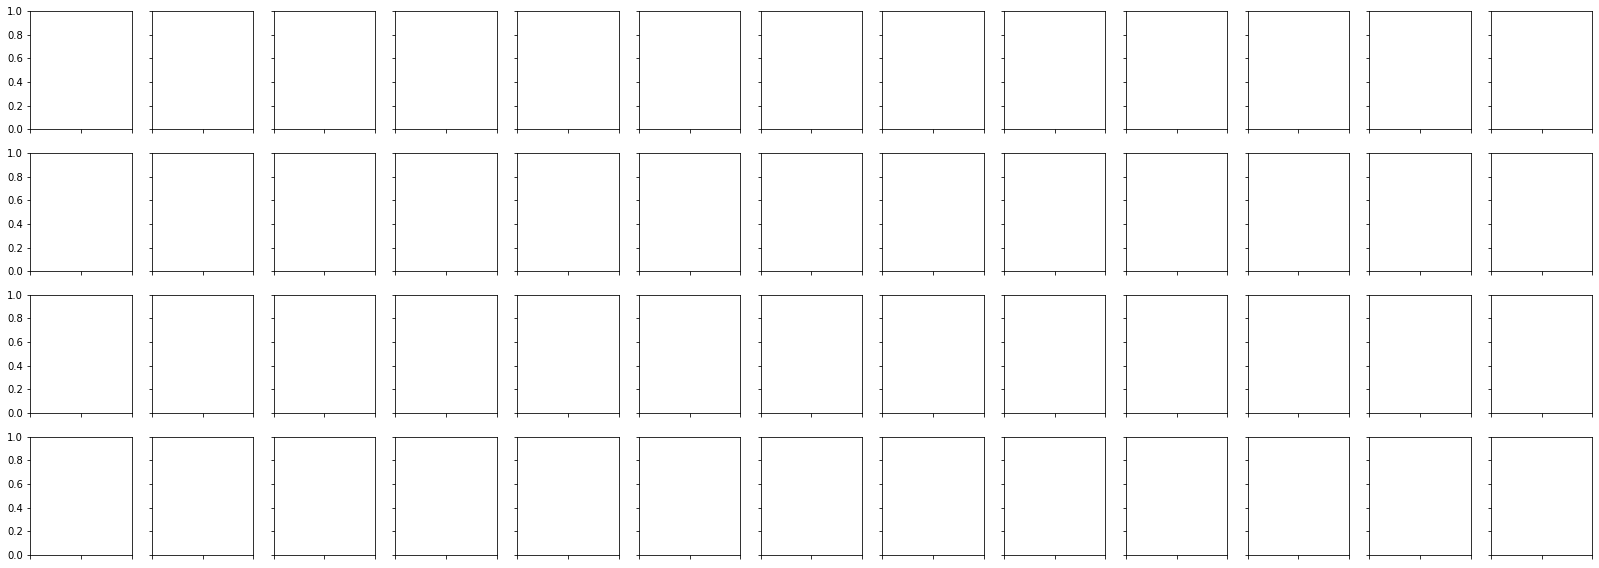

In [29]:
dataDir = Path("./output")
count=0
for fname in sorted(os.listdir(dataDir)):
    if fname.endswith("model"):
        continue
    fullPath = dataDir/Path(fname)
    count+=1
    #print(fullPath)
fig, ax = plt.subplots(4, 13)
for row in range(4):
    for col in range(13):
        csvName = f"output/{int(800+col*100)}_64_{int(2**row * 256)}.csv"
        plt.setp(ax[row][col].get_xticklabels(), visible=False)
        if col != 0:
            plt.setp(ax[row][col].get_yticklabels(), visible=False)
        df = pd.read_csv(csvName)
fig.set_size_inches(28, 10)